In [2]:
import os

In [3]:
pip install ges

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.7 MB/s eta 0:00:00


In [4]:
import ges as GES

In [5]:
!pip install scikit-learn pyro-ppl causalml econml pgmpy dowhy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/

In [6]:
#Load the librarys
import numpy as np
import pandas as pd
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
from sklearn.model_selection import train_test_split
#from causalml.inference.tree import CausalForest
from dowhy import CausalModel
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from econml.dml import CausalForestDML
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import pyro
import torch

In [7]:
pip install ges

In [8]:
import ges as GES

In [9]:
from dowhy import gcm

In [10]:
import networkx as nx

In [11]:
# Important Libraries

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Step 1: Data Engineering


In [12]:
# @title Importing the Data
# The raw link to the CSV file in the GitHub repository
url = 'https://raw.githubusercontent.com/dzrich/PhD_Research_in_CausalML/main/Data/CreditRiskDataset.csv'

# Load the CSV file into a pandas DataFrame
CreditRiskDataset = pd.read_csv(url)

# Display the first few rows of the dataset
print(CreditRiskDataset.head())

   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  \
0                 0.59                         Y                           3  

## First Look at the data:
Looking the Type of Data
Null Numbers
Unique values
The first rows of our dataset


In [13]:
#Searching for Missings,type of data and also know the shape of data
print(CreditRiskDataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
 12  OTHER_DEBT                  32581 non-null  float64
 13  TIME_WITH_BANK              325

#### Drop unwanted Columns

In [54]:
df = CreditRiskDataset.drop(['Unnamed: 15','Unnamed: 16'], axis=1)

#### Impute missing values

In [55]:
df['person_emp_length'] = df['person_emp_length'].fillna(df['person_emp_length'].mean())
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].mean())

In [56]:
df["person_emp_length"].fillna((df["person_emp_length"].median()), inplace = True)
df["loan_int_rate"].fillna((df["loan_int_rate"].mean()), inplace = True)
#check
df["loan_int_rate"].isnull().sum()

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




0

# Perfom Some explorations:
 - Starting by distribuition of column Age.
 - Some Seaborn graphical
 - Columns crossing

**Let's start looking through target variable and their distribuition

Text(0.5, 0, 'Default Status')

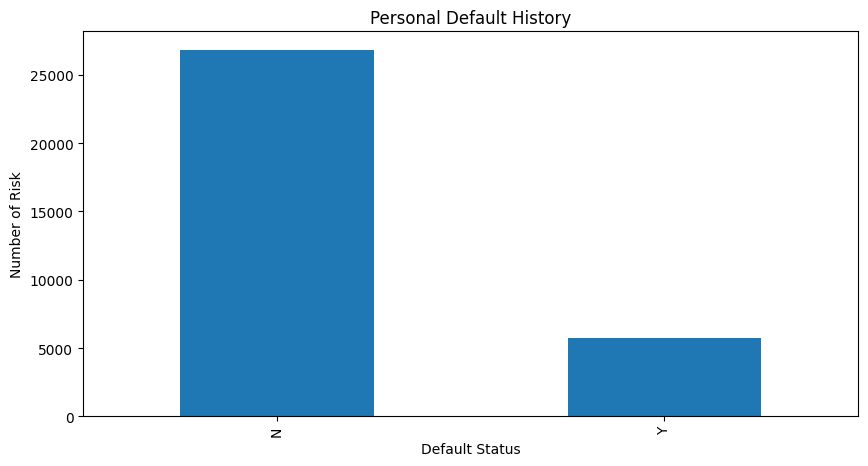

In [17]:
df.cb_person_default_on_file.value_counts().plot(kind='bar', figsize =(10,5))
plt.title("Personal Default History")
plt.ylabel('Number of Risk')
plt.xlabel('Default Status')

In [18]:
df_good = df.loc[df["cb_person_default_on_file"] == 'N']['person_age'].values.tolist()
df_bad = df.loc[df["cb_person_default_on_file"] == 'Y']['person_age'].values.tolist()
df_age = df['person_age'].values.tolist()

Text(0.5, 0, 'Age')

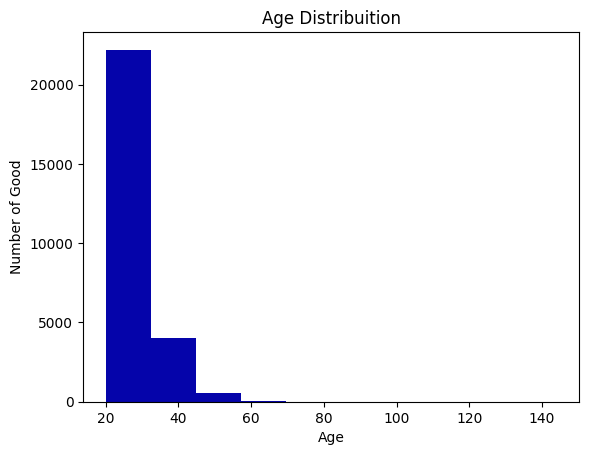

In [19]:
trace0 = plt.hist( x= df_good,bins=None,range=None,density=False,weights=None,
    cumulative=False,bottom=None,histtype='bar',align='mid',orientation='vertical',
    rwidth=None,log=False,color='#0504aa',label='N',stacked=False)
plt.title("Age Distribuition")
plt.ylabel('Number of Good')
plt.xlabel('Age')

Text(0.5, 0, 'Age')

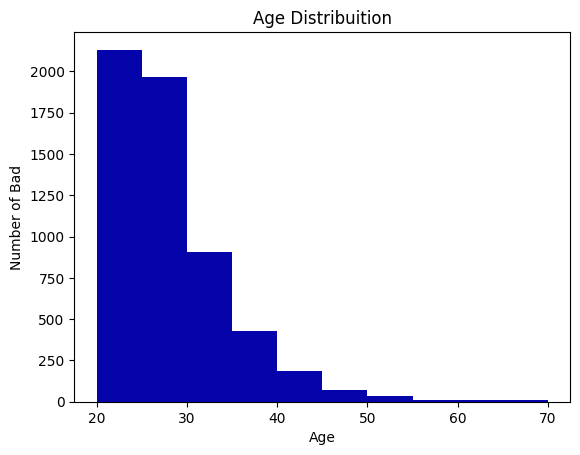

In [20]:
trace1 = plt.hist(x=df_bad,bins=None,range=None,density=False,weights=None,
    cumulative=False,bottom=None,histtype='bar',align='mid',orientation='vertical',
    rwidth=None,log=False,color='#0504aa',label='Good',stacked=False)
plt.title("Age Distribuition")
plt.ylabel('Number of Bad')
plt.xlabel('Age')

Text(0.5, 0, 'Age')

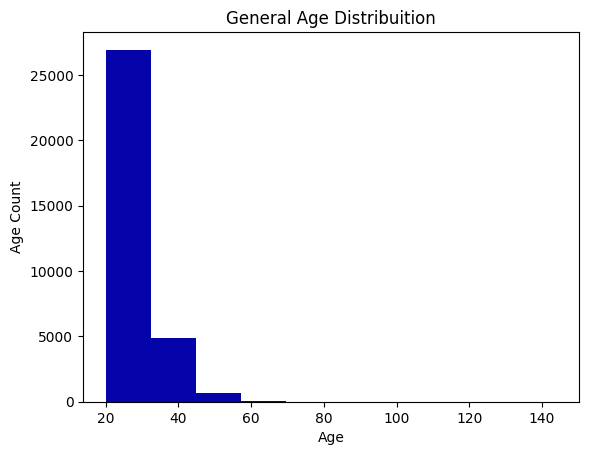

In [21]:
trace2 = plt.hist(x=df_age,bins=None,range=None,density=False,weights=None,
    cumulative=False,bottom=None,histtype='bar',align='mid',orientation='vertical',
    rwidth=None,log=False,color='#0504aa',label='Good',stacked=False)
plt.title("General Age Distribuition")
plt.ylabel('Age Count')
plt.xlabel('Age')

In [57]:
df_good = df[df["cb_person_default_on_file"] == 'N']
df_bad = df[df["cb_person_default_on_file"] == 'Y']

## Encoding the Independent Variable
Use two classes: First, The column transform the classes from the compose module of Sklearn library. Second, the OHE class module for preprocessing from the Sklearn library

In [58]:
df = pd.get_dummies(df, columns=['person_home_ownership'],dtype= float)
df = pd.get_dummies(df, columns=['loan_intent'],dtype= float)
df = pd.get_dummies(df, columns=['loan_grade'],dtype= float)
df = pd.get_dummies(df, columns=['cb_person_default_on_file'],dtype= float)

## **Correlational Machine Learning:**

**Looking at the correlation of the data**

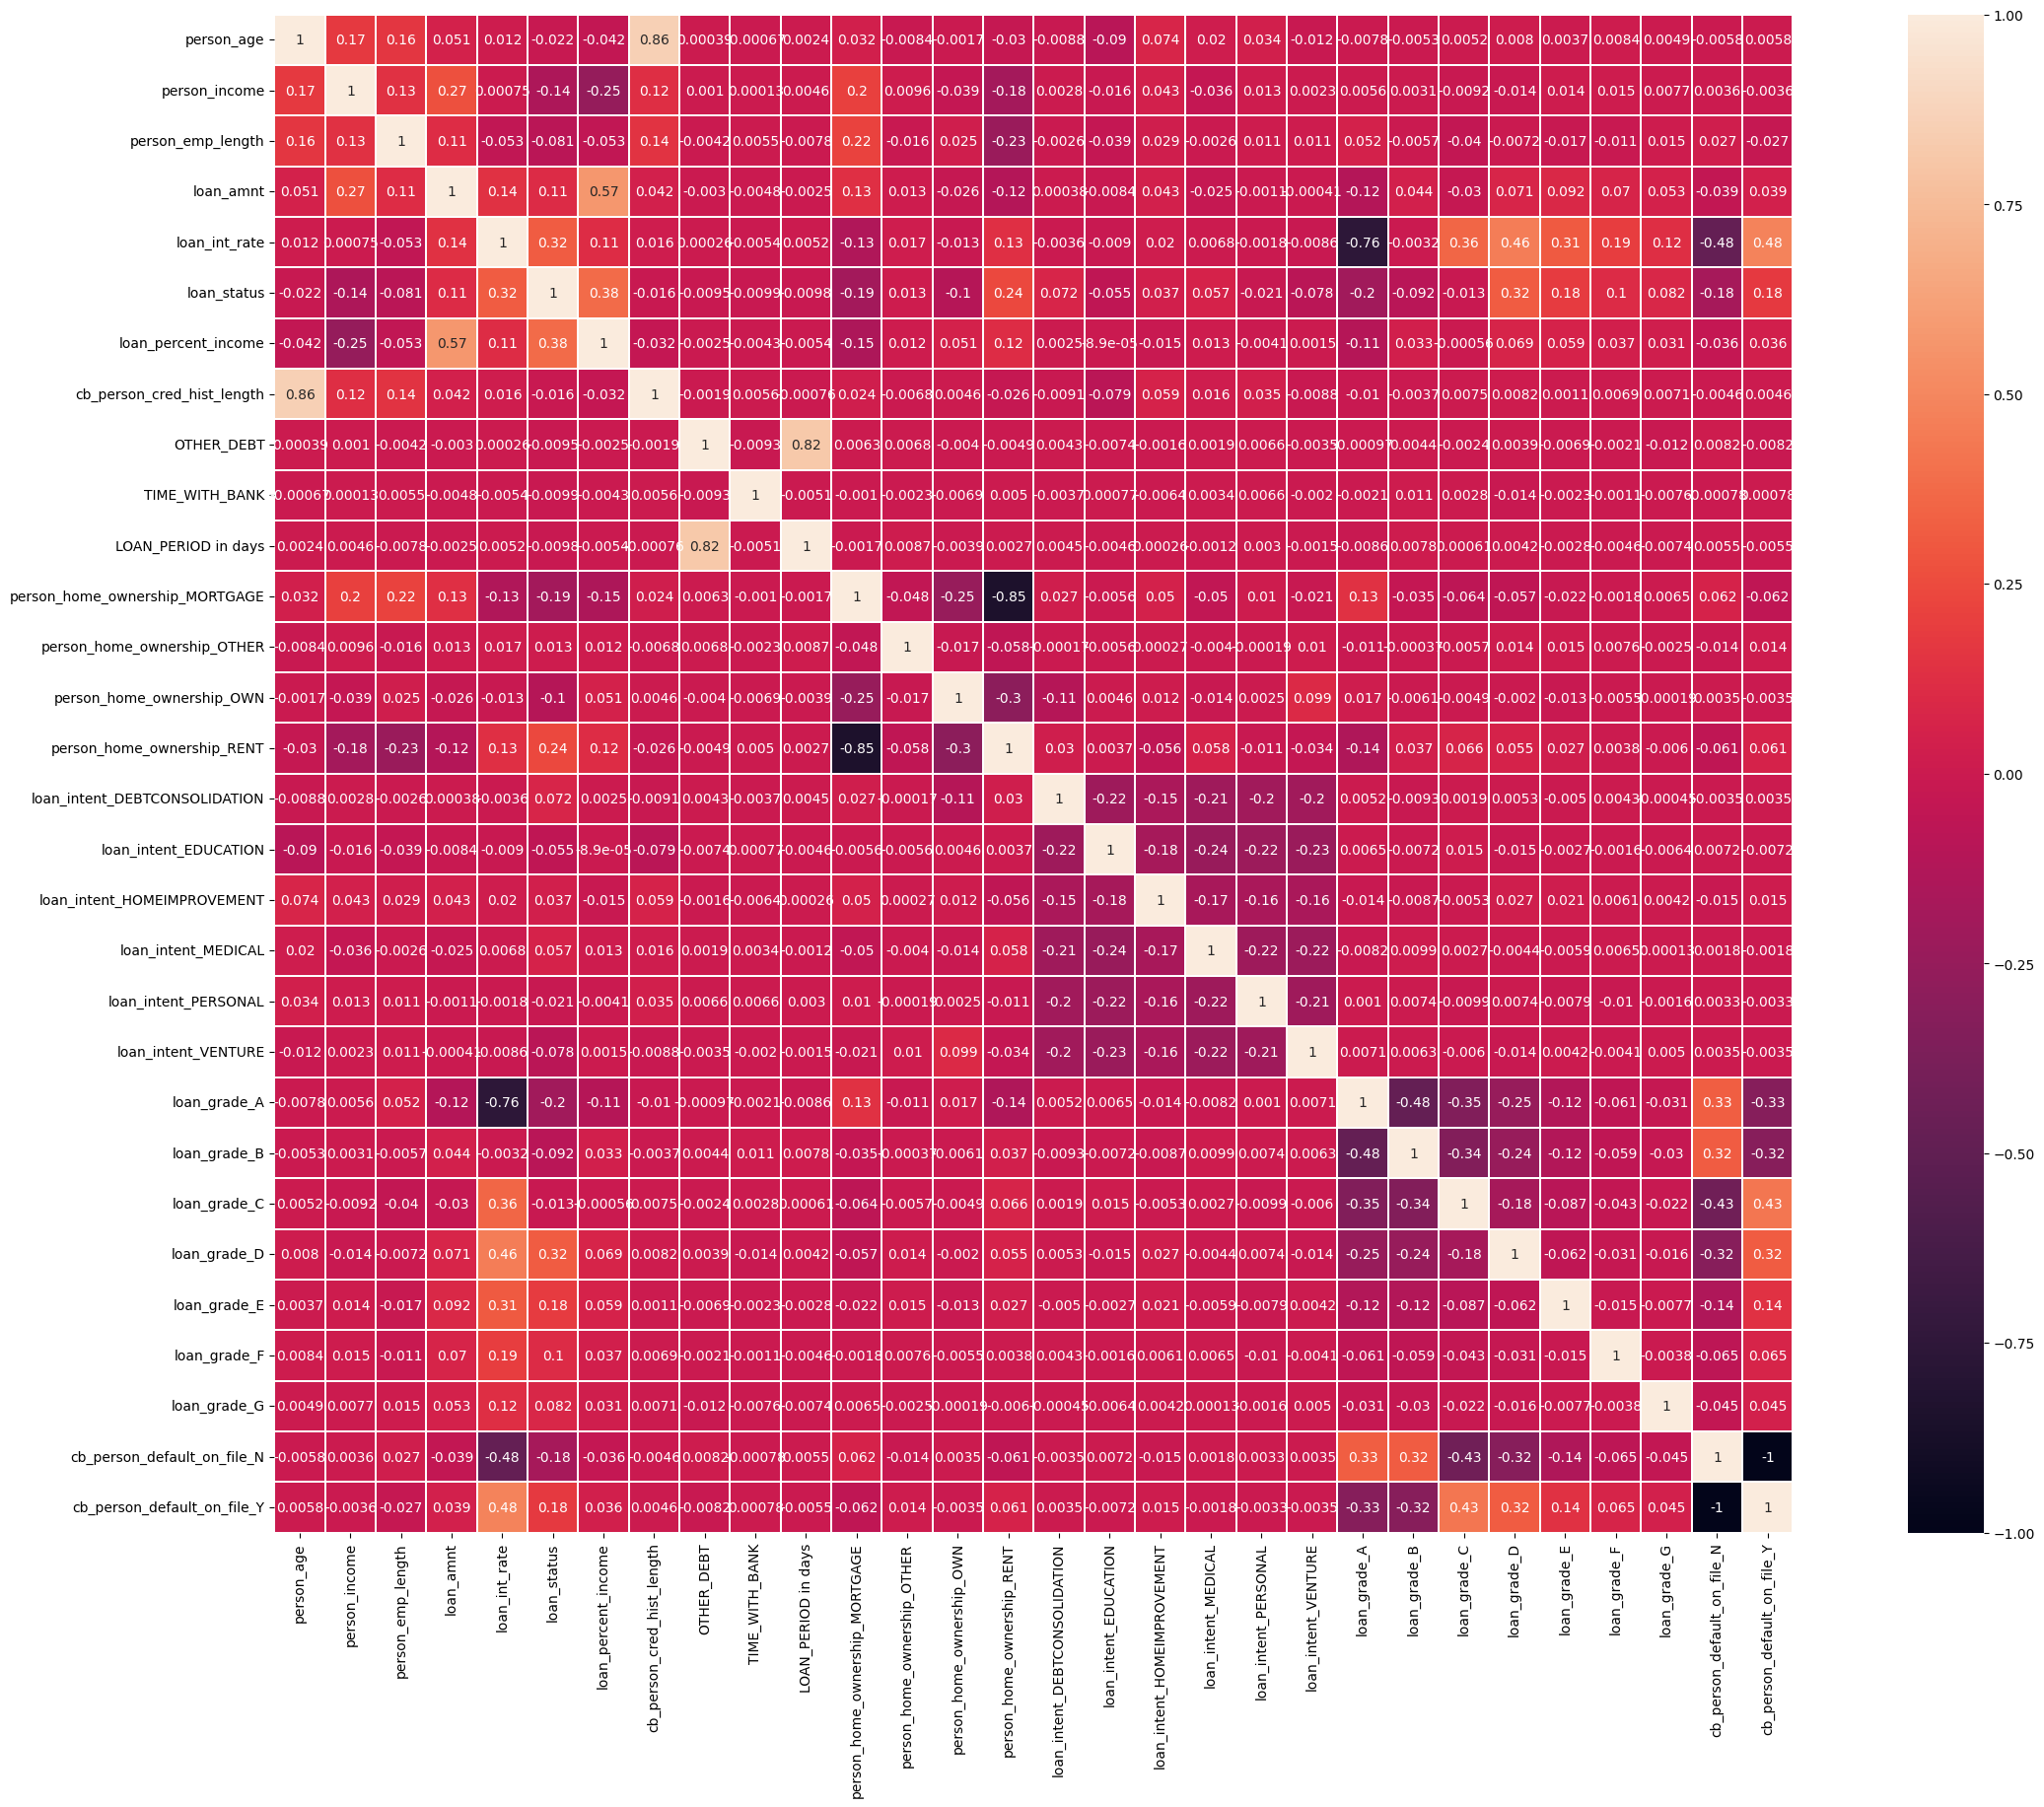

In [24]:
plt.figure(figsize=(30,20))
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True,  linecolor='white', annot=True)
plt.show()

In [59]:
df=df.drop(['cb_person_default_on_file_Y'], axis=1)

In [26]:
df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,OTHER_DEBT,TIME_WITH_BANK,...,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N
0,22,59000,123.0,35000,16.02,1,0.59,3,31681.020000,7,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,21,9600,5.0,1000,11.14,0,0.10,2,31437.140180,6,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,25,9600,1.0,5500,12.87,1,0.57,3,23979.127160,9,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,23,65500,4.0,35000,15.23,1,0.53,2,2602.283057,5,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,24,54400,8.0,35000,14.27,1,0.55,4,59393.203400,8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Preprocessing:
Importing ML librarys
Setting X and y variables to the prediction
Splitting Data

In [27]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.linear_model import LogisticRegression


In [28]:
df['loan_amnt'] = np.log(df['loan_amnt'])# Transforming 'loan amount ' and 'person_income' columns
df['person_income'] = np.log(df['person_income'])

## Splitting the dataset into the Training set and Test set

In [60]:
#Creating the X and y variables
X = df.drop('cb_person_default_on_file_N', axis = 1).values
y = df['cb_person_default_on_file_N'].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

## Feature Scaling

In [30]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [31]:
print(X_train)

[[-0.2746665   2.26064696  1.28731712 ... -0.17160693 -0.08566264
  -0.0443651 ]
 [ 0.50686454  0.26030224 -0.4394184  ... -0.17160693 -0.08566264
  -0.0443651 ]
 [-0.89989133 -1.61421283  0.05393461 ... -0.17160693 -0.08566264
  -0.0443651 ]
 ...
 [-0.2746665   1.72812048 -0.9327714  ...  5.82727051 -0.08566264
  -0.0443651 ]
 [-0.2746665   2.02399569 -1.17944791 ... -0.17160693 -0.08566264
  -0.0443651 ]
 [-0.11836029  0.27530586  1.53399362 ... -0.17160693 -0.08566264
  -0.0443651 ]]


## Training the Logistic Regression model on the Training set

In [32]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state = 0)
#classifier.fit(X_train, y_train)

In [33]:
classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

## Predicting the Test set results

In [34]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 1.]
 [1. 1.]
 [1. 1.]]


In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score
#cm = confusion_matrix(y_test, y_pred)
print(pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames = ['Predicted']))
#print(cm)

print(accuracy_score(y_test, y_pred))

Predicted  0.0   1.0
Actual              
0.0        738   753
1.0        722  5933
0.8189295359685735


In [36]:
y_pred = classifier.predict(X_test)

print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

0.8189295359685735


[[ 738  753]
 [ 722 5933]]


              precision    recall  f1-score   support

         0.0       0.51      0.49      0.50      1491
         1.0       0.89      0.89      0.89      6655

    accuracy                           0.82      8146
   macro avg       0.70      0.69      0.69      8146
weighted avg       0.82      0.82      0.82      8146



## ROC Curve

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score
roc_curve(y_test, y_pred)

(array([0.        , 0.50503018, 1.        ]),
 array([0.        , 0.89151014, 1.        ]),
 array([inf,  1.,  0.]))

In [38]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

Text(0.5, 1.0, 'ROC curve')

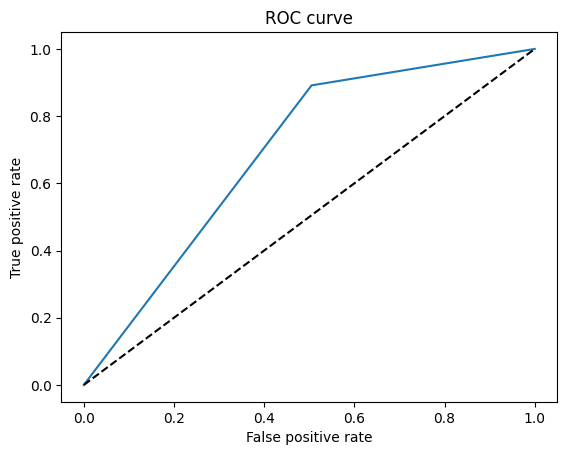

In [39]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

# Overfitting & regularization
In order to avoid overfitting, it is necessary to use additional techniques **(e.g. cross-validation, regularization, early stopping, pruning, or Bayesian priors).**


#### Regularization
is a way of finding a good **bias-variance tradeoff** by tuning the complexity of the model. It is a very useful method to handle:
 - collinearity (high correlation among features),
 - filter out noise from data, and
 - eventually prevent overfitting.
**The concept behind regularization is to introduce additional information (bias) to penalize extreme parameter weights.**

## k-fold cross-validation

The k-fold cross-validation procedure is a standard method for estimating the performance of a machine learning algorithm or configuration on a dataset.

A single run of the k-fold cross-validation procedure may result in a noisy estimate of model performance. Different splits of the data may result in very different results.

It is common to evaluate machine learning models on a dataset using k-fold cross-validation.

The k-fold cross-validation procedure divides a limited dataset into k non-overlapping folds. Each of the k folds is given an opportunity to be used as a held back test set, whilst all other folds collectively are used as a training dataset. A total of k models are fit and evaluated on the k hold-out test sets and the mean performance is reported.

Repeated k-fold cross-validation provides a way to improve the estimated performance of a machine learning model. This involves simply repeating the cross-validation procedure multiple times and reporting the mean result across all folds from all runs. This mean result is expected to be a more accurate estimate of the true unknown underlying mean performance of the model on the dataset, as calculated using the standard error.

In [40]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=20, shuffle=True)
# create and fitting  model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
y_pred = model.predict(X_test)

print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.825 (0.005)
0.8208936901546772


[[ 750  741]
 [ 718 5937]]


              precision    recall  f1-score   support

         0.0       0.51      0.50      0.51      1491
         1.0       0.89      0.89      0.89      6655

    accuracy                           0.82      8146
   macro avg       0.70      0.70      0.70      8146
weighted avg       0.82      0.82      0.82      8146



In [41]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

LR: 0.827214 (0.007743)


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7caaa4355c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.27.so: cannot open shared object file: No such file or directory


LDA: 0.827747 (0.007986)
KNN: 0.827992 (0.005908)
CART: 0.827747 (0.008062)
NB: 0.827993 (0.008056)
RF: 0.827583 (0.008263)
SVM: 0.830202 (0.007392)
XGB: 0.826806 (0.005165)


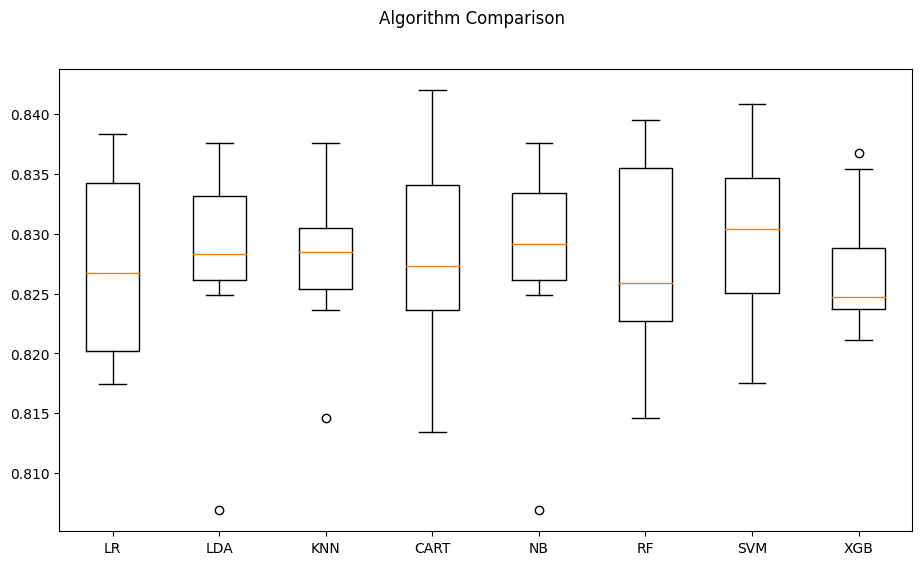

In [42]:
# to feed the random state
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
#scoring = 'recall'
for name, model in models:
        kfold = KFold(n_splits=10, shuffle=True, random_state=seed,)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [43]:
np.where(np.isnan(X_train)) #X_train.isna().any()

(array([], dtype=int64), array([], dtype=int64))

##Causal Machine Learning

In [44]:
import dowhy
from dowhy import CausalModel

In [45]:
# Simulate some credit risk data
np.random.seed(42)
n = 1000
X = np.random.normal(0, 1, size=(n, 3))  # 3 features: credit score, income, loan amount
T = np.random.binomial(1, p=0.5, size=(n,))  # Treatment: 0 (low interest rate), 1 (high interest rate)
Y = (X[:, 0] * 0.8 - X[:, 1] * 0.3 + T * 1.5 + np.random.normal(0, 1, size=n)) > 0  # Outcome: default or not
data = pd.DataFrame(np.column_stack([X, T, Y]), columns=["credit_score", "income", "loan_amount", "interest_rate", "default"])

In [46]:
data.head()

,credit_score,income,loan_amount,interest_rate,default
0,0.496714,-0.138264,0.647689,1.0,1.0
1,1.523030,-0.234153,-0.234137,1.0,1.0
2,1.579213,0.767435,-0.469474,0.0,1.0
3,0.542560,-0.463418,-0.465730,1.0,1.0
4,0.241962,-1.913280,-1.724918,0.0,1.0


In [47]:
data['interest_rate'].unique()

array([1., 0.])

In [61]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      32581 non-null  int64  
 1   person_income                   32581 non-null  int64  
 2   person_emp_length               32581 non-null  float64
 3   loan_amnt                       32581 non-null  int64  
 4   loan_int_rate                   32581 non-null  float64
 5   loan_status                     32581 non-null  int64  
 6   loan_percent_income             32581 non-null  float64
 7   cb_person_cred_hist_length      32581 non-null  int64  
 8   OTHER_DEBT                      32581 non-null  float64
 9   TIME_WITH_BANK                  32581 non-null  int64  
 10  LOAN_PERIOD in days             32581 non-null  float64
 11  person_home_ownership_MORTGAGE  32581 non-null  float64
 12  person_home_ownership_OTHER     

In [64]:
median_interest_rate = df['loan_int_rate'].median()
df['loan_int_rate1'] = (df['loan_int_rate'] >= median_interest_rate).astype(int)

In [65]:
df = df.drop(['loan_int_rate'], axis=1)

In [66]:
# Define the SCM using DoWhy and specify the causal graph
common_causes=["person_age","person_income", "OTHER_DEBT", "person_emp_length",
                "loan_amnt","loan_percent_income","loan_status", "cb_person_cred_hist_length",
                "TIME_WITH_BANK", "LOAN_PERIOD in days","person_home_ownership_MORTGAGE",
                "person_home_ownership_OTHER","person_home_ownership_OWN","person_home_ownership_RENT",
                "loan_intent_DEBTCONSOLIDATION","loan_intent_EDUCATION","loan_intent_HOMEIMPROVEMENT",
                "loan_intent_MEDICAL","loan_intent_PERSONAL","loan_intent_VENTURE","loan_grade_A",
                "loan_grade_B","loan_grade_C","loan_grade_D","loan_grade_E","loan_grade_F","loan_grade_G"]

model = CausalModel(
    data=df,
    treatment="loan_int_rate1",
    outcome="cb_person_default_on_file_N",
    common_causes=common_causes,
    instruments=None  # You can add instruments for IV methods
)

# Identify causal effect
identified_estimand = model.identify_effect()

# Estimate the effect using propensity score matching
estimate = model.estimate_effect(identified_estimand, method_name= "backdoor.propensity_score_matching") #"backdoor.linear_regression""backdoor.propensity_score_matching"
print("Estimated Causal Effect:", estimate.value)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Estimated Causal Effect: -0.3154292378993892


## Solve for the Above

### 1. Increase the Maximum Number of Iterations for the Logistic Regression Solver

In [67]:
# Increase the number of iterations for the logistic regression solver
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    method_params={
        "propensity_score_model": {
            "max_iter": 10000  # Increase the number of iterations
        }
    }
)

### Scale the Data

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      32581 non-null  int64  
 1   person_income                   32581 non-null  int64  
 2   person_emp_length               32581 non-null  float64
 3   loan_amnt                       32581 non-null  int64  
 4   loan_status                     32581 non-null  int64  
 5   loan_percent_income             32581 non-null  float64
 6   cb_person_cred_hist_length      32581 non-null  int64  
 7   OTHER_DEBT                      32581 non-null  float64
 8   TIME_WITH_BANK                  32581 non-null  int64  
 9   LOAN_PERIOD in days             32581 non-null  float64
 10  person_home_ownership_MORTGAGE  32581 non-null  float64
 11  person_home_ownership_OTHER     32581 non-null  float64
 12  person_home_ownership_OWN       

In [68]:
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Convert scaled data back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

common_causes=["person_age","person_income", "OTHER_DEBT", "person_emp_length",
                "loan_amnt","loan_percent_income","loan_status", "cb_person_cred_hist_length",
                "TIME_WITH_BANK", "LOAN_PERIOD in days","person_home_ownership_MORTGAGE",
                "person_home_ownership_OTHER","person_home_ownership_OWN","person_home_ownership_RENT",
                "loan_intent_DEBTCONSOLIDATION","loan_intent_EDUCATION","loan_intent_HOMEIMPROVEMENT",
                "loan_intent_MEDICAL","loan_intent_PERSONAL","loan_intent_VENTURE","loan_grade_A",
                "loan_grade_B","loan_grade_C","loan_grade_D","loan_grade_E","loan_grade_F","loan_grade_G","propensity_score"]


# Use scaled data for the causal model
model = CausalModel(
    data=scaled_df,
    treatment="loan_int_rate1",  # Binary treatment
    outcome="cb_person_default_on_file_N",  # Outcome
    common_causes=common_causes
)

# Re-identify and estimate the causal effect
identified_estimand = model.identify_effect()

# Estimate the causal effect using PSM with increased max_iter
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    method_params={
        "propensity_score_model": {
            "max_iter": 10000  # Increase the number of iterations
        }
    }
)
print("Estimated Causal Effect:", estimate.value)


ERROR:dowhy.causal_estimator:Propensity score methods are applicable only for binary treatments


Exception: Propensity score methods are applicable only for binary treatments

### Apply Domain Knowledge and Feature Importance

In [ ]:
common_causes = [
    "person_age", "person_income", "OTHER_DEBT", "person_emp_length",
    "loan_amnt", "loan_percent_income", "cb_person_cred_hist_length", "TIME_WITH_BANK",
    "person_home_ownership_MORTGAGE", "loan_intent_EDUCATION"
]

model = CausalModel(
    data=scaled_df,
    treatment="loan_int_rate1",
    outcome="cb_person_default_on_file_N",
    common_causes=common_causes
)


##GES algorithm:
This is a score-based algorithm that searches for the causal graph that best fits the data according to a scoring function.

In [ ]:
!pip install --force-reinstall pgmpy==0.1.18

  Using cached networkx-3.4.1-py3-none-any.whl.metadata (6.3 kB)
  Using cached numpy-2.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scipy-1.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
  Using cached torch-2.4.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached statsmodels-0.14.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.2 kB)
  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metad

In [ ]:
#from pgmpy.estimators import GES
#from pgmpy.models import BayesianNetwork

In [ ]:
##!git clone https://github.com/pgmpy/pgmpy
#%cd pgmpy/
#!pip install -r requirements.txt
#!python setup.py install

In [ ]:
# Restart the runtime after installing pgmpy
import os
os.kill(os.getpid(), 9)

In [ ]:
from pgmpy.estimators import GES

ImportError: cannot import name 'GES' from 'pgmpy.estimators' (/usr/local/lib/python3.10/dist-packages/pgmpy/estimators/__init__.py)

In [ ]:
#from pgmpy.models import BayesianNetwork

In [ ]:
#ges = GES(df)

In [52]:
from pgmpy.models import BayesianNetwork

# Initialize the GES estimator
#ges = GES(df)

# Estimate the causal graph using the GES algorithm
#estimated_model = ges.estimate()

# Print the estimated causal graph
#print(estimated_model.edges())

# Create a Bayesian Network from the estimated model
#model = BayesianNetwork(estimated_model.edges())

# Fit the Bayesian Network to the data
#model.fit(df)

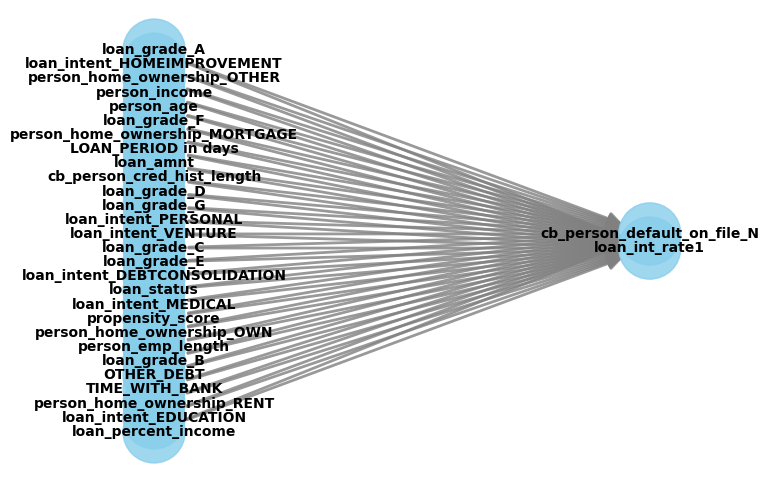

Fitting causal mechanism of node cb_person_default_on_file_N: 100%|██████████| 3/3 [00:00<00:00,  7.09it/s]


In [53]:
causal_model = gcm.InvertibleStructuralCausalModel(nx.DiGraph([('loan_amnt', 'loan_int_rate1'), ('loan_int_rate1', 'cb_person_default_on_file_N')])) # X -> Y -> Z
gcm.auto.assign_causal_mechanisms(causal_model, df)
model.view_model()
gcm.fit(causal_model, df)

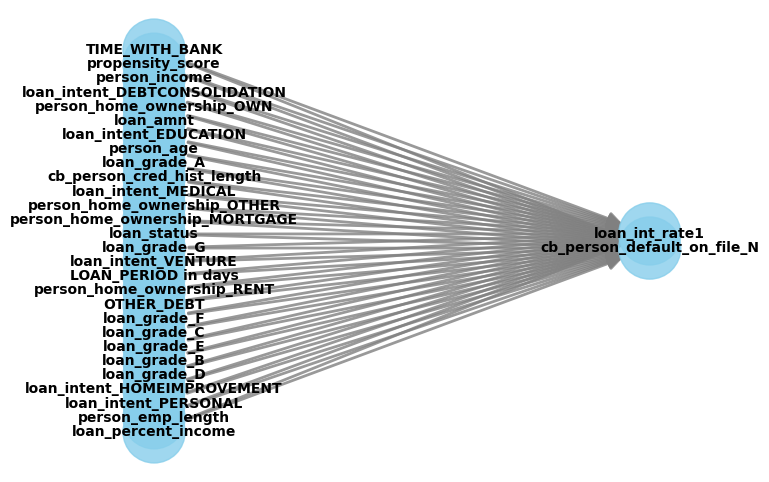

Fitting causal mechanism of node cb_person_default_on_file_N: 100%|██████████| 3/3 [00:00<00:00,  6.81it/s]


In [ ]:
causal_model1 = gcm.InvertibleStructuralCausalModel(
        nx.DiGraph([
            ('loan_amnt', 'loan_int_rate1'),
            ('loan_amnt', 'cb_person_default_on_file_N'),
            #('loan_amnt', 'propensity_score'),  # Add propensity_score as a node
            # ... any other causal relationships ...
        ])
    )

gcm.auto.assign_causal_mechanisms(causal_model1, df)
model.view_model()
gcm.fit(causal_model1, df)

##Intervention
Finally, let’s perform an intervention on X. Here, we explicitly perform the intervention
: X=1

In [ ]:
#Interventions

samples = gcm.interventional_samples(causal_model1,
                                     {'loan_amnt': lambda loan_amnt: 100},
                                     num_samples_to_draw=500)
samples.head(2)

,loan_amnt,loan_int_rate1,cb_person_default_on_file_N
0,100,2,1
1,100,2,1


In [ ]:
samples = gcm.interventional_samples(causal_model1,
                                     {'loan_amnt': lambda loan_amnt: loan_amnt + 0.5},
                                     num_samples_to_draw=500)
samples.head(2)

,loan_amnt,loan_int_rate1,cb_person_default_on_file_N
0,10.180344,1,1
1,10.074983,1,1


## **Counterfactual**

In [ ]:
observed_data = df[(df['loan_amnt'] >= 0.2) & (df['loan_int_rate1'] >= 0.5) & (df['cb_person_default_on_file_N'] == 0)]


In [ ]:
observed_data.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_status,loan_percent_income,cb_person_cred_hist_length,OTHER_DEBT,TIME_WITH_BANK,LOAN_PERIOD in days,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,loan_int_rate1
0,22,10.985293,123.0,10.463103,1,0.59,3,31681.02000,7,316.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
4,24,10.904119,8.0,10.463103,1,0.55,4,59393.20340,8,593.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
21,25,11.827736,9.0,10.457373,0,0.25,2,48655.75437,2,486.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
24,22,11.289782,3.0,10.432644,1,0.42,4,52589.23555,3,525.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
26,21,9.305651,3.0,8.428362,1,0.42,3,52753.41234,3,527.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1


In [ ]:
# Assuming you want to select rows where loan_amnt is 52, loan_int_rate1 is 5, and cb_person_default_on_file_N is 0
#observed_data = df[(df['loan_amnt'] == 52) & (df['loan_int_rate1'] == 5) & (df['cb_person_default_on_file_N'] == 0)]

# Now use observed_data in counterfactual_samples
gcm.counterfactual_samples(
    causal_model1,
    {'loan_amnt': lambda loan_amnt: 50},  # Assuming loan_amount is the treatment
    observed_data=observed_data
)


,loan_amnt,loan_int_rate1,cb_person_default_on_file_N
0,50,1,0.0
1,50,1,0.0
2,50,1,0.0
3,50,1,0.0
4,50,1,0.0
...,...,...,...
5704,50,1,0.0
5705,50,1,0.0
5706,50,2,0.0
5707,50,1,0.0


## **2. Bayesian Network for Causal Discovery using pgmpy:**

In [ ]:
# Define the structure of a Bayesian Network
model2 = BayesianNetwork([("loan_amnt", "cb_person_default_on_file_N"), ("person_income", "cb_person_default_on_file_N"), ("loan_int_rate1", "cb_person_default_on_file_N")])

# Estimate parameters based on data
model2.fit(df, estimator=MaximumLikelihoodEstimator)

# Query the model to perform inference
from pgmpy.inference import VariableElimination
inference = VariableElimination(model2)
result = inference.map_query(variables=["cb_person_default_on_file_N"], evidence={"loan_int_rate1": 1})
print("MAP Query Result for Default:", result)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

MAP Query Result for Default: {'cb_person_default_on_file_N': 1.0}


## **3. Causal Forest (Causal Tree Ensembles):**

In [ ]:
# Use the CausalML library's CausalForest
X = df[["loan_amnt", "person_income", "loan_int_rate1"]].values
y = df["cb_person_default_on_file_N"].values
trtmnt = df["loan_int_rate1"].values

causal_forest = CausalForestDML()
causal_forest.fit(X, T=trtmnt,Y=y)

# Estimate treatment effect (e.g., the effect of interest_rate on default)
treatment_effect = causal_forest.estimate_ate(X_test=X, T=treatmnt, Y=y)
print("Causal Forest Treatment Effect:", treatment_effect)

TypeError: CausalForestDML.fit() got multiple values for argument 'Y'

In [ ]:
from econml.dml import CausalForestDML
from sklearn.linear_model import MultiTaskLassoCV

# set parameters for causal forest
causal_forest = CausalForestDML(criterion='het',
                                n_estimators=10000,
                                min_samples_leaf=10,
                                max_depth=None,
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=MultiTaskLassoCV(),
                                model_y=MultiTaskLassoCV(),
                                )

# fit train data to causal forest model
causal_forest.fit(y, trtmnt, X=X)
# estimate the CATE with the test set
causal_forest.const_marginal_ate(X_test)

ValueError: For mono-task outputs, use LassoCVCV

In [ ]:
import matplotlib.pyplot as plt

# set plot size
fig, ax = plt.subplots(figsize=(12, 8))
# plot lines for treatment effects and confidence intervals
ax.plot(z['cate'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE', color='indigo')
ax.plot(z['lb'],
        marker='.', linestyle='-', linewidth=0.5, color='steelblue')
ax.plot(z['ub'],
        marker='.', linestyle='-', linewidth=0.5, color='steelblue')
# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()

## **4. Invariant Causal Prediction (ICP):**

In [ ]:
# You can use the econml library for Double Machine Learning (DML), which includes invariant causal prediction.
# Let's apply it for credit scoring causal effect estimation.

estimator = CausalForestDML(model_y=RandomForestRegressor(), model_t=RandomForestRegressor())
estimator.fit(Y, T, X=X)

# Estimate the causal effect of treatment on the outcome
treatment_effect = estimator.effect(X)
print("Estimated Treatment Effect using Causal Forest DML:", treatment_effect)

## **5. Counterfactual Reasoning:**

In [ ]:
# Using DoWhy's counterfactual reasoning
counterfactuals = model.estimate_counterfactuals(data, treatment="interest_rate", outcome="default")
print("Counterfactuals:", counterfactuals)

## **6. Propensity Score Matching (PSM):**

In [ ]:
from causalml.propensity import ElasticNetPropensityModel
ps_model = ElasticNetPropensityModel()
ps_model.fit(X, treatment)

# Estimate propensity scores
ps_scores = ps_model.predict_proba(X)
print("Propensity Scores:", ps_scores)

## **7. Instrumental Variable Methods:**

In [ ]:
from econml.iv.dml import OrthoIV
# Assume 'instrument' is the instrumental variable we have in our dataset
instrument = data['instrument'].values

# Define the OrthoIV model
iv_model = OrthoIV(model_y=RandomForestRegressor(), model_t=RandomForestRegressor())
iv_model.fit(Y, T, X=X, Z=instrument)

# Estimate causal effect
treatment_effect_iv = iv_model.effect(X)
print("Treatment Effect using IV:", treatment_effect_iv)

## **8. Time Series Causal Models:**

In [ ]:
# For time-series data, you can use Granger Causality tests or other transfer entropy methods.
# Granger causality can be applied using statsmodels.
from statsmodels.tsa.stattools import grangercausalitytests

# Apply Granger causality to the dataset
grangercausalitytests(data[["loan_amount", "default"]], maxlag=2)

## **9. Model Deployment (e.g., Flask):**

In [ ]:
from flask import Flask, request, jsonify
import joblib

app = Flask(__name__)

# Assume causal_model is your trained causal ML model
joblib.dump(causal_forest, "causal_model.pkl")
causal_model = joblib.load("causal_model.pkl")

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    prediction = causal_model.estimate_ate(X_test=[data['credit_score'], data['income'], data['loan_amount']])
    return jsonify({"treatment_effect": prediction})

if __name__ == "__main__":
    app.run(debug=True)

https://github.com/dzrich/PhD_Research_in_CausalML/tree/main/Data